In [1]:
#!/usr/bin/python3

# IMPORTNAT  this code accept only .fa file as proteome

def parse_oma_db(oma_database_address):
    
    ############### Parsing OMA db ####################
    ###################################################

    oma_db = db.Database(oma_database_address)

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- OMA data is parsed and its release name is:", oma_db.get_release_name())
    list_oma_speices = [z.uniprot_species_code for z in oma_db.tax.genomes.values()] 
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- There are",len(list_oma_speices),"species in the OMA database.")
    
    return (oma_db, list_oma_speices)


def parse_proteome(list_oma_speices):
    
    ############### Parsing query proteome of species #######
    #########################################################

    
    # IMPORTNAT  this code accept only .fa file as proteome
    project_files = listdir(project_folder+"/omamer_search/proteome/")

    query_species_names = []
    for file in project_files:
        if file.split(".")[-1] == "fa":
            file_name_split = file.split(".")[:-1]
            query_species_names.append('.'.join(file_name_split))
        if file.split(".")[-1] == "fasta":
            file_name_split = file.split(".")[:-1]
            query_species_names.append('.'.join(file_name_split))

    # we may assert existence of query_species_name+".fa/hogmap"
    prots_record_allspecies = [ ]
    for query_species_name in query_species_names:
        prot_address = project_folder +"omamer_search/proteome/"+ query_species_name + ".fa" 
        
        prots_record = list(SeqIO.parse(prot_address, "fasta")) 
        prots_record_allspecies.append(prots_record)

    query_species_num = len(query_species_names)    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- The are",str(query_species_num),"species in the proteome folder.")

    # for development
    for species_i in range(query_species_num):
        len_prot_record_i = len( prots_record_allspecies[species_i] )
        species_name_i = query_species_names[species_i]
        #print(species_name_i,len_prot_record_i)
        if species_name_i in list_oma_speices: 
            current_time = datetime.now().strftime("%H:%M:%S")
            print(current_time,"- the species",species_name_i," already exists in the oma database, remove them first")
            exit()

      
    # The proteins are parsed using  Bio.SeqIO.parse
    # the first part of the header line before space 
    # >tr|A0A2I3FYY2|A0A2I3FYY2_NOMLE Uncharacterized protein OS=Nomascus leucogenys OX=61853 GN=CLPTM1L PE=3 SV=1
    # will be ">tr|A0A2I3FYY2|A0A2I3FYY2_NOMLE"
    # [i.id for i in prots_record_allspecies[0] if len(i.id)!=30 and len(i.id)!=22 ] #'sp|O47892|CYB_NOMLE',
    

    
    return (query_species_names, prots_record_allspecies)


def parse_hogmap_omamer(query_species_names):

    ################### Parsing omamer's output  ########
    #####################################################
    
    prots_hogmap_name_allspecies = []
    prots_hogmap_hogid_allspecies = []
    prots_hogmap_subfscore_allspecies = []
    prots_hogmap_seqlen_allspecies = []
    prots_hogmap_subfmedseqlen_allspecies = []

    for query_species_name in query_species_names:
        omamer_output_address = project_folder + "omamer_search/hogmap/"+ query_species_name + ".hogmap"     
        omamer_output_file = open(omamer_output_address,'r');
        prots_hogmap_name = []
        prots_hogmap_hogid = []
        prots_hogmap_subfscore = []
        prots_hogmap_seqlen = []
        prots_hogmap_subfmedseqlen = []
        
        for line in omamer_output_file:
            line_strip=line.strip()
            if not line_strip.startswith('qs'):
                line_split= line_strip.split("\t")    
                #if line_split[1]!='na':
                prots_hogmap_name.append(line_split[0])
                prots_hogmap_hogid.append(line_split[1])
                prots_hogmap_subfscore.append(line_split[4]) # subfamily
                prots_hogmap_seqlen.append(line_split[5])
                prots_hogmap_subfmedseqlen.append(line_split[6])
                
        prots_hogmap_name_allspecies.append(prots_hogmap_name)
        prots_hogmap_hogid_allspecies.append(prots_hogmap_hogid)
        prots_hogmap_subfscore_allspecies.append(prots_hogmap_subfscore)
        prots_hogmap_seqlen_allspecies.append(prots_hogmap_seqlen)
        prots_hogmap_subfmedseqlen_allspecies.append(prots_hogmap_subfmedseqlen)
    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- There are ",len(prots_hogmap_name_allspecies)," species in the hogmap folder.")
    print(current_time,"- The first species",query_species_names[0]," contains ",len(prots_hogmap_hogid_allspecies[0])," proteins.")
    print(current_time,"- The first protein of first species is ", prots_hogmap_name_allspecies[0][0])

    hogmap_allspecies = (prots_hogmap_name_allspecies, prots_hogmap_hogid_allspecies, prots_hogmap_subfscore_allspecies, prots_hogmap_seqlen_allspecies, prots_hogmap_subfmedseqlen_allspecies)
    return  hogmap_allspecies
    
    
    
def filter_prot_mapped(query_species_names, query_prot_records_species,query_prot_names_species_mapped):
    # omamer remove very small proteins, 
    # so  we lose track of order comparing hogmap and fasta file
    # the goal here is to remove those from seq record (of the fasta file)
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- Filtering proteins started.")

    query_prot_records_species_filtered=[]
    for species_idx in range(len(query_species_names)):    
        # from fasta file
        query_species_name=query_species_names[species_idx]
        print(query_species_name)
        query_prot_records_species_i = query_prot_records_species[species_idx]
        query_prot_ids_records = [record.id for record in query_prot_records_species_i]

        # from hogmap file
        # without proteins that are not mapped on any hogs
        query_prot_names_species_i = query_prot_names_species_mapped[species_idx]

        if len(query_prot_names_species_i) != len(query_prot_records_species_i):

            query_prot_records_filterd=[]
            for query_prot_name in query_prot_names_species_i:
                if query_prot_name in query_prot_ids_records:
                    prot_record_idx = query_prot_ids_records.index(query_prot_name)
                    prot_record = query_prot_records_species_i[prot_record_idx]
                    query_prot_records_filterd.append(prot_record)
                else:
                    current_time = datetime.now().strftime("%H:%M:%S")                    
                    print(current_time,"- Error",query_species_name, query_prot_name)

            current_time = datetime.now().strftime("%H:%M:%S")        
            print(current_time,"- For the species", query_species_name, ", few proteins were ignored by omamer.")
            print(current_time,"- before filtering: in hogmap", len(query_prot_names_species_i), "in proteome", len(query_prot_records_species_i))
            print(current_time,"- After filtering:  in hogmap", len(query_prot_names_species_i), "in proteome", len(query_prot_records_filterd))            
            

        else:
            query_prot_records_filterd = query_prot_records_species_i

        query_prot_records_species_filtered.append(query_prot_records_filterd)
    current_time = datetime.now().strftime("%H:%M:%S")        
    print(current_time,"- For the rest of species, all proteins were mapped using OMAmer.")

    return query_prot_records_species_filtered


def run_one_msa(seqRecords_queries):
    ############## MSA  ##############
    ##################################
    #current_time = datetime.now().strftime("%H:%M:%S")
    #print(current_time, "- working on new OG with length of ",len(seqRecords_OG_queries))
    
    
    wrapper_mafft = mafft.Mafft(seqRecords_queries,datatype="PROTEIN") 
    # MAfft error: Alphabet 'U' is unknown. -> add --anysymbol argument needed to define in the sourse code
    # workaround sed "s/U/X/g"
    
    wrapper_mafft.options.options['--retree'].set_value(1)


    run_mafft = wrapper_mafft() # it's wrapper  storing the result  and time 
    time_taken_mafft = wrapper_mafft.elapsed_time

    result_mafft = wrapper_mafft.result 
    time_taken_mafft2 = wrapper_mafft.elapsed_time
    
    current_time = datetime.now().strftime("%H:%M:%S")
    #print(current_time,"- time elapsed for MSA: ",time_taken_mafft2)
    print(current_time,"- MSA for an OG is just finished: ",time_taken_mafft2)

    return(result_mafft)





def draw_tree(msa, tree_out_file):
    ############## Tree inference  ###################
    ##################################################

    wrapper_tree=fasttree.Fasttree(msa,datatype="PROTEIN")
    wrapper_tree.options.options['-fastest']    
    result_tree1 = wrapper_tree()

    time_taken_tree = wrapper_tree.elapsed_time 
    time_taken_tree

    result_tree2 = wrapper_tree.result
    tree_nwk=str(result_tree2["tree"])
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- ",len(tree_nwk))

    #out_name_tree=project_folder+"fastoma_core/_tree.txt"
    file1 = open(tree_out_file,"w")
    file1.write(tree_nwk)
    file1.write(";\n")
    
    file1.close() 
    return tree_nwk



def merge_msa(list_msas):
    # each element of msa should be  a MultipleSeqAlignment
    wrapper_mafft_merge = mafft.Mafft(list_msas, datatype="PROTEIN") 
    wrapper_mafft_merge.options['--merge'].active = True
    merged = wrapper_mafft_merge()
    
    
    print(len(list_msas),"msas are merged into one with the length of ",len(merged),len(merged[0]) )
    return merged




    
    
def compact_distance_matrix_tree(tree_input):

    # tree_input   in ete3 format
    # output  a vector upper triangulare 
    
    tree_leaves=[]
    for node in tree_input.traverse(strategy="postorder"):
        if node.is_leaf() : 
            node_name = node.name
            tree_leaves.append(node_name)


    leaves_num = len(tree_leaves)
    distance_matrix = np.zeros([leaves_num,leaves_num])

    for i in range(leaves_num):
        for j in range(leaves_num):
            if i < j:
                value= round(tree_input.get_distance(tree_leaves[i],tree_leaves[j]),3)
                distance_matrix[i][j]= value
                distance_matrix[j][i]= value

    y=[]
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            if i<j:
                val= distance_matrix[i][j]
                y.append(val)
    return (y,tree_leaves)

    

from scipy.cluster.hierarchy import dendrogram, linkage, ward, leaves_list, fcluster

from ete3 import Tree

import numpy as np
import pyoma.browser.db as db
import concurrent.futures
import ast
import pickle

from pyoma.browser.models import ProteinEntry

#import zoo
#zoo.__file__

import zoo.wrappers.aligners.mafft as mafft  # mafft should be installed beforehand
import zoo.wrappers.treebuilders.fasttree as fasttree

from datetime import datetime
from sys import argv
from os import listdir
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq, UnknownSeq
from Bio.Align import MultipleSeqAlignment

from collections import defaultdict


import matplotlib   #for development 
#matplotlib.use('Agg')
import matplotlib.pyplot as plt


import pyoma.browser.db as db
from pyoma.browser.hoghelper import build_hog_to_og_map


import time

In [2]:


# if __name__ == "__main__":

    
#     # a global variable
#     #project_folder = argv[1]
#     project_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/"
    
#     oma_database_address = project_folder+"omamer_database/oma_path/OmaServer.h5"
    
#     print("program has started. The oma database address is in ",oma_database_address)
    
#     (oma_db, list_oma_speices) = parse_oma_db(oma_database_address)

     
#     (query_species_names, query_prot_records_species) = parse_proteome(list_oma_speices)   
    
#     hogmap_allspecies = parse_hogmap_omamer(query_species_names)
    
#     (query_prot_names_species_mapped, prots_hogmap_hogid_allspecies, prots_hogmap_subfscore_allspecies, prots_hogmap_seqlen_allspecies, prots_hogmap_subfmedseqlen_allspecies) = hogmap_allspecies 

#     query_prot_records_species_filtered =  filter_prot_mapped(query_species_names, query_prot_records_species, query_prot_names_species_mapped)

#     print(len(query_prot_records_species_filtered),len(query_prot_records_species_filtered[0]))
    


## Write  rootHoGs as fasta file

In [3]:

# prots_hogmap_rhogid_allspecies = []
# for prots_hogmap_hogid in prots_hogmap_hogid_allspecies:
#     prots_hogmap_rhogid = []
#     for prot_hogmap_hogid in prots_hogmap_hogid:
#         prot_hogmap_rhogid=prot_hogmap_hogid.split(".")[0]
#         prots_hogmap_rhogid.append(prot_hogmap_rhogid)
        
#     prots_hogmap_rhogid_allspecies.append(prots_hogmap_rhogid)

    
    
# rhogid_prot_idx_dic = {}

# for species_idx in range(len(query_species_names)):
    
#     species_name = query_species_names[species_idx]
    
#     prots_hogmap_rhogid = prots_hogmap_rhogid_allspecies[species_idx]
    
#     for prots_hogmap_idx in range(len(prots_hogmap_rhogid)):
        
#         prot_hogmap_rhogid = prots_hogmap_rhogid[prots_hogmap_idx]
        
#         if prot_hogmap_rhogid in rhogid_prot_idx_dic:
#             rhogid_prot_idx_dic[prot_hogmap_rhogid].append((species_idx,prots_hogmap_idx))
#         else:
#             rhogid_prot_idx_dic[prot_hogmap_rhogid] = [(species_idx,prots_hogmap_idx)]
            
            
            
# print(len(rhogid_prot_idx_dic), rhogid_prot_idx_dic['HOG:0018405'])


# rhogids_prot_records_query = [ ]

# rhogids_list = []
# for rhogid in rhogid_prot_idx_dic.keys() :
    
#     if rhogid != "na" and len(rhogid)>1:
#         rhogids_list.append(rhogid)
#         rhogid_prot_idx =  rhogid_prot_idx_dic[rhogid]
#         rhogid_prot_records = []
#         for (species_idx, prots_hogmap_idx) in rhogid_prot_idx:
#             prot_record = query_prot_records_species_filtered[species_idx][prots_hogmap_idx] 
#             #print(prot_record)
#             rhogid_prot_records.append(prot_record)
     
    
#     rhogids_prot_records_query.append(rhogid_prot_records)
    
    
    
# print(len(rhogids_prot_records_query),len(rhogids_prot_records_query[0]))

In [4]:

# rhogids_prot_records = []

# for rhogid_idx in range(len(rhogids_list)):
    
#     rhogid_prot_records_query= rhogids_prot_records_query[rhogid_idx] 

#     rhogid = rhogids_list[rhogid_idx]

    
#     rhogid_num= int(rhogid.split(":")[1])
#     rhogids_prot_records_oma = []
#     for hog_elements in oma_db.member_of_fam(rhogid_num):   # this gets the member of roothog 2 (HOG:000002)
#         prot_hog_element = ProteinEntry(oma_db, hog_elements)
#         #print(prot_hog_element.omaid, prot_hog_element.hog_family_nr, len(prot_hog_element.sequence),prot_hog_element.sequence[0])
        
#         rhogids_prot_records_oma.append(SeqRecord(Seq(prot_hog_element.sequence), id=prot_hog_element.omaid))
#     rhogids_prot_records.append(rhogids_prot_records_oma +  rhogid_prot_records_query)
    
# print(len(rhogids_prot_records), len(rhogids_prot_records[0]))

# address_out_hog="/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/hog_out/"
# # mkdir hog_out


# for rhogid_idx in range(len(rhogids_list)):
    
#     rhogid_prot_records= rhogids_prot_records[rhogid_idx] 

#     rhogid = rhogids_list[rhogid_idx]

#     SeqIO.write(rhogid_prot_records, address_out_hog+"HOG_"+str(int(rhogid.split(":")[1]))+".fa", "fasta")
    
# print("Each of ",len(rhogids_list),"hogs were written into separat fasta file.")    
    

## now consider only one rHOG (including   omaDB+query proteins )

In [5]:
address_working_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/"

address_out_hog= address_working_folder+ "hog_out/"

prot_address = address_out_hog+"HOG_"+str(10019)+".fa"
rhog_i= list(SeqIO.parse(prot_address, "fasta")) 
print("number of proteins in the rHOG", len(rhog_i))

id_list=[]
for rec in rhog_i:
    id_list.append(rec.id)
species_names_rhog = [i[:5] for i in id_list]
species_names_uniqe = set(species_names_rhog)
print("number of unique species in the rHOG",len(species_names_uniqe))

number of proteins in the rHOG 39
number of unique species in the rHOG 24


In [6]:
#a=[1,2,1,23,4]; a.count(1)
# for i in species_names_uniqe:
#     print(species_names_rhog.count(i))

# for rec in rhog_i:
#     if rec.id[:5] in list_species_under_study:
#         print(rec.id)
        




## read species tree

In [92]:
import os
# import numpy as np
# from sys import argv
# from datetime import datetime
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
import ete3


fast_tree_address = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/primate_oma/v27_10/fastoma_core_splice_subf0.5/"
fast_tree_address += "_100_msa_concatanated.txt.contree"+"_collapsed__94_0.001"


# fast_tree_address="/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/primate_oma/standard/"
# fast_tree_address += "concatanted.fasta.contree_collapsed__94_0.001"


print(fast_tree_address)
print(round(os.path.getsize(fast_tree_address)/1000),"kb")

fast_tree= ete3.Tree(fast_tree_address) # ,format=0
print("length of tree is ",len(fast_tree))


species_tree_leaves=[]
for node in fast_tree.traverse(strategy="postorder"):
    if node.is_leaf() : 
        node_name = node.name
        species_tree_leaves.append(node_name)

species_tree_leaves_uniq = [i for i in species_tree_leaves if i[-1]!='_']
print(len(species_tree_leaves_uniq), len(species_tree_leaves),species_tree_leaves_uniq)



fast_tree.prune(species_tree_leaves_uniq, preserve_branch_length=True)
#print(fast_tree)
fast_tree.write()

# species_tree_leaves=[]
# for node in fast_tree.traverse(strategy="postorder"):
#     if node.is_leaf() : 
#         node_name = node.name
#         species_tree_leaves.append(node_name)

# species_tree_leaves_uniq = [i for i in species_tree_leaves if i[-1]!='_']
# print(len(species_tree_leaves_uniq), len(species_tree_leaves),species_tree_leaves_uniq)


#fast_tree.prune(['PANPA', 'PANTR', 'BOVIN', 'MOUSE','HUMAN', 'GORGO','MICMU','PROCO' ], preserve_branch_length=True) # 
#list_species_under_study= ["Pan_paniscus", "Pan_troglodytes"] # , "Bos_taurus", "Mus_musculus"
#['PANPA', 'PANTR', 'BOVIN', 'MOUSE']

list_species_under_study= ['PANPA', 'PANTR', 'BOVIN', 'MOUSE']
#['BOVIN', 'MOUSE']
fast_tree.prune(list_species_under_study, preserve_branch_length=True) #  
#fast_tree.prune([ 'BOVIN', 'MOUSE' ], preserve_branch_length=True) #  

print(fast_tree)

        #print(no_list)
#"PNAB"   ("GORGO"  "HUMAN")

fast_tree.write()



# check all internal node has a nem

num_leaves_no_name = 0

for node in fast_tree.traverse(strategy = "postorder"):
    
    node_name = node.name
    if len(node_name) <1: 
        if node.is_leaf():
            num_leaves_no_name += 1
            node.name = "leaf_"+str(num_leaves_no_name)
        else:
            node_children = node.children
            list_children_names = [node_child.name for node_child in node_children]
            node.name = '_'.join(list_children_names)
    print(node_name)
            

               
#print(num_leaves_no_name)
print(fast_tree)  
fast_tree.write()


/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/primate_oma/v27_10/fastoma_core_splice_subf0.5/_100_msa_concatanated.txt.contree_collapsed__94_0.001
1 kb
length of tree is  35
25 35 ['COLAP', 'BOVIN', 'MOUSE', 'OTOGA', 'MICMU', 'PROCO', 'CARSF', 'SAIBB', 'CALJA', 'AOTNA', 'GORGO', 'PANTR', 'PANPA', 'HUMAN', 'PONAB', 'NOMLE', 'MACNE', 'MACFA', 'MANLE', 'CERAT', 'CHLSB', 'PAPAN', 'MACMU', 'RHIBE', 'RHIRO']

      /-BOVIN
   /-|
  |   \-MOUSE
--|
  |   /-PANPA
   \-|
      \-PANTR
BOVIN
MOUSE

PANPA
PANTR



      /-BOVIN
   /-|
  |   \-MOUSE
--|
  |   /-PANPA
   \-|
      \-PANTR


'((BOVIN:0.0886258,MOUSE:0.104671)100:0.0473944,(PANPA:0.0230622,PANTR:0.00904152)100:0.0110677);'

## fast getHOG v2


      /-BOVIN
   /-|
  |   \-MOUSE
--|
  |   /-PANPA
   \-|
      \-PANTR
** now working on node  BOVIN
** now working on node  MOUSE
** now working on node  BOVIN_MOUSE
BOVIN
11:30:35 - MSA for an OG is just finished:  0.3497276306152344
MOUSE
11:30:36 - MSA for an OG is just finished:  0.15112543106079102
*****  2
2 msas are merged into one with the length of  6 666
length is  6 666
11:30:37 -  175
(BOVIN09898:0.088984372,((BOVIN09896:0.0,BOVIN09897:0.0):0.074374249,MOUSE44014:0.070091173)1.000:0.167813492,(MOUSE01292:0.147998218,MOUSE01293:0.181646904)0.915:0.041841267)

   /-BOVIN09898
  |
  |      /-BOVIN09896
  |   /-|
--|--|   \-BOVIN09897
  |  |
  |   \-MOUSE44014
  |
  |   /-MOUSE01292
   \-|
      \-MOUSE01293
length of tree is  6
(((BOVIN09896:0,BOVIN09897:0)1:0.0743742,MOUSE44014:0.0700912)1:0.0839067,(BOVIN09898:0.0889844,(MOUSE01292:0.147998,MOUSE01293:0.181647)0.915:0.0418413)1:0.0839067);

         /-BOVIN09896
      /-|
   /-|   \-BOVIN09897
  |  |
--|   \-MOUSE44014


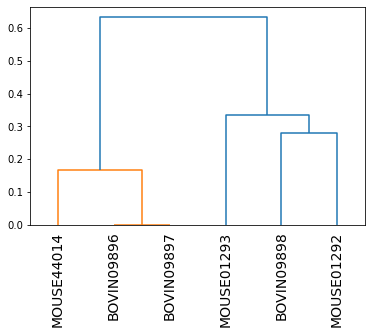

[1 1 1 2 3 4]
Number of hog at this level is  4 . The number of proteins per hog is [3, 1, 1, 1]
11:30:38 - MSA for an OG is just finished:  0.25725579261779785
** now working on node  PANPA
** now working on node  PANTR
** now working on node  PANPA_PANTR
PANPA
11:30:38 - MSA for an OG is just finished:  0.11538219451904297
PANTR
11:30:38 - MSA for an OG is just finished:  0.13169503211975098
*****  2
2 msas are merged into one with the length of  3 665
length is  3 665
11:30:39 -  68
((PANPA23689:0.0,PANTR26407:0.0):0.186998492,PANTR26412:0.186998492)

      /-PANPA23689
   /-|
--|   \-PANTR26407
  |
   \-PANTR26412
length of tree is  3
((PANPA23689:0,PANTR26407:0)1:0.186998,PANTR26412:0.186998);

      /-PANPA23689
   /-|
--|   \-PANTR26407
  |
   \-PANTR26412
3
dendogram saved in /work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/dendogram_2.jpg


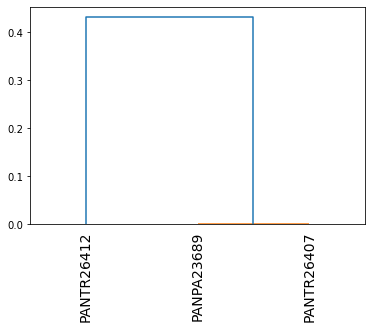

[1 1 2]
Number of hog at this level is  2 . The number of proteins per hog is [2, 1]
11:30:40 - MSA for an OG is just finished:  0.15856051445007324
** now working on node  BOVIN_MOUSE_PANPA_PANTR
BOVIN_MOUSE
sub msa for internal node BOVIN_MOUSE is read from dic.
PANPA_PANTR
sub msa for internal node PANPA_PANTR is read from dic.
*****  2
2 msas are merged into one with the length of  9 666
length is  9 666
11:30:41 -  277
(MOUSE01292:0.164438325,(MOUSE44014:0.0471794,((BOVIN09896:0.0,BOVIN09897:0.0):0.078594392,(PANPA23689:0.0,PANTR26407:0.0):0.084331141)0.455:0.015246102)1.000:0.183264545,(BOVIN09898:0.09769058,(MOUSE01293:0.163371641,PANTR26412:0.112689962)0.943:0.042101973)0.510:0.033712638)

   /-MOUSE01292
  |
  |   /-MOUSE44014
  |  |
  |--|      /-BOVIN09896
  |  |   /-|
--|  |  |   \-BOVIN09897
  |   \-|
  |     |   /-PANPA23689
  |      \-|
  |         \-PANTR26407
  |
  |   /-BOVIN09898
   \-|
     |   /-MOUSE01293
      \-|
         \-PANTR26412
length of tree is  9
((MOUS

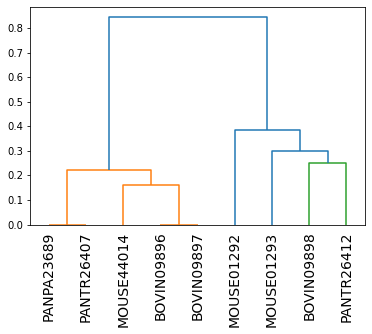

[1 1 1 1 1 4 2 3 2]
Number of hog at this level is  4 . The number of proteins per hog is [5, 2, 1, 1]
11:30:42 - MSA for an OG is just finished:  0.3753950595855713


In [93]:
print(fast_tree)


dic_sub_msas= {}

i_clustering = 0

thres1 =.3

for node in fast_tree.traverse(strategy = "postorder"):
    print("** now working on node ",node.name) # node_children
    
    if not node.is_leaf() : 

        node_children = node.children
        

        sub_msa_list = []
        for node_child in node_children:
            print(node_child.name)
            node_child_name = node_child.name
            if  node_child.is_leaf():
                #print(node_child.name)
                node_species_name = node_child_name
                intrest_list = [idx  for idx in range(len(species_names_rhog)) if species_names_rhog[idx] == node_species_name ]
                rhog_part = [rhog_i[i] for i in intrest_list]
                sub_msa = run_one_msa(rhog_part)
                
            else: # the child  node is not leaf
                print("sub msa for internal node",node_child_name,"is read from dic.")
                if node_child_name in dic_sub_msas:
                    sub_msa  = dic_sub_msas[node_child_name]
                else:
                    print("issue, no sub msa for the internal node ")
                
            sub_msa_list.append(sub_msa)
                
                
                


        # if one child is leaf, the rest is internal node 
                
                
        if len(sub_msa_list)>1:
            print("***** ", len(sub_msa_list))#, ' '.join([k.id for i in sub_msa_list for j in i  for k in j ]))
            
            i_clustering += 1 
            time.sleep(1)     # shall I wait to have all  msa run finsihed? 
            merged_msa = merge_msa(sub_msa_list) 
            
            print("length is ",len(merged_msa),len(merged_msa[0]))
            
            tree_out_file =  address_working_folder + "tree"+str(i_clustering)+".nwk"
            tree_out_raw = draw_tree(merged_msa, tree_out_file)
            print(tree_out_raw)

            tree_out = Tree(tree_out_raw+";", format=0)
            print(tree_out)
            print("length of tree is ",len(tree_out))
            
            
            R = tree_out.get_midpoint_outgroup()
            tree_out.set_outgroup(R)
            print(tree_out.write())
            print(tree_out)

            
            

            (y,tree_leaves) = compact_distance_matrix_tree(tree_out)

            print(len(y))


            Z = linkage(y, 'ward') # ward  single
            # print(Z)
            fig = plt.figure() # figsize=(10, 10)
            dn = dendrogram(Z, color_threshold = thres1*max(Z[:,2]), labels=tree_leaves, leaf_font_size=14, leaf_rotation=90) # is defualt color_threshold= 0.7*max(Z[:,2]). 
            
            dendogram_out_file =  address_working_folder + "dendogram_"+str(i_clustering)+".jpg"
            print("dendogram saved in",dendogram_out_file )
            plt.savefig(dendogram_out_file, bbox_inches='tight')
            plt.show()

            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster

            clusters_1 = fcluster(Z,thres1*max(Z[:,2]), criterion='distance') 

            print(clusters_1)
            #

            sub_msas_list_a = []
            for cluster_id in range(1,max(clusters_1)+1):
                sub_msa = [  merged_msa[int(i)]   for i in list(np.where(clusters_1==cluster_id)[0])   ]
                sub_msas_list_a.append(sub_msa)

            print("Number of hog at this level is ",len(sub_msas_list_a),". The number of proteins per hog is", [len(i) for i in  sub_msas_list_a])    
            sub_msas_list_a_aligned  = run_one_msa(sub_msas_list_a)
            dic_sub_msas[node.name]  = sub_msas_list_a_aligned
        
        elif node.is_root():
            
            print("reach root of the tree")
        else:
            print("this node has only one child, what to do ?",node_children)
            #
    else:
        a=1 
        # the node that is being traversing is a leaf.
        
            
            

In [100]:
print(tree_out)


      /-MOUSE44014
     |
   /-|      /-BOVIN09896
  |  |   /-|
  |  |  |   \-BOVIN09897
  |   \-|
--|     |   /-PANPA23689
  |      \-|
  |         \-PANTR26407
  |
  |   /-MOUSE01292
   \-|
     |   /-BOVIN09898
      \-|
        |   /-MOUSE01293
         \-|
            \-PANTR26412


In [99]:
tree_out

Tree node 'D' (0x7f7b590e58e)

In [59]:
dic1={}
dic1[node]={"a","b","c"}
dic1[node]

{'a', 'b', 'c'}

In [101]:
i=0

species_name_dic={}

for node in tree_out.traverse(strategy = "postorder"):
    #print("** now working on node ",node.name) # node_children
    
    
    if node.is_leaf() :
        species_name_dic[node] = {node.name[:5]}
        
    else:
        i +=1
        node.name= "s/D"+str(i)

        leaves_list = node.get_leaves()
        species_name_set = set([ i.name[:5] for i in leaves_list])
        species_name_dic[node] = species_name_set

        
        node_children = node.children
        #print(node_children)
        node_children_species_list = [species_name_dic[node_child] for node_child in node_children]
    
        node_children_species_intersection = set.intersection(*node_children_species_list)
        
        if  node_children_species_intersection :
            print("*",node_children_species_list)
            node.name = "D"
        else:
            node.name = "S"
            

            
tree_out
    

* [{'BOVIN'}, {'BOVIN'}]
* [{'MOUSE'}, {'MOUSE', 'BOVIN', 'PANTR'}]
* [{'MOUSE', 'BOVIN', 'PANTR', 'PANPA'}, {'MOUSE', 'BOVIN', 'PANTR'}]


Tree node 'D' (0x7f7b590e58e)

In [102]:

tree_out.write(format=1)

'((MOUSE44014:0.0471794,((BOVIN09896:0,BOVIN09897:0)D:0.0785944,(PANPA23689:0,PANTR26407:0)S:0.0843311)S:0.0152461)S:0.0916323,(MOUSE01292:0.164438,(BOVIN09898:0.0976906,(MOUSE01293:0.163372,PANTR26412:0.11269)S:0.042102)S:0.0337126)D:0.0916323);'

In [103]:
print(tree_out)


      /-MOUSE44014
     |
   /-|      /-BOVIN09896
  |  |   /-|
  |  |  |   \-BOVIN09897
  |   \-|
--|     |   /-PANPA23689
  |      \-|
  |         \-PANTR26407
  |
  |   /-MOUSE01292
   \-|
     |   /-BOVIN09898
      \-|
        |   /-MOUSE01293
         \-|
            \-PANTR26412


In [84]:
tree_out

Tree node 'D' (0x7f7b701bceb)

In [34]:
for node in tree_out.traverse(strategy = "postorder"):
    print("** now working on node ",node.name) # node_children
    
    if not node.is_leaf() : 

        print(node.label)


** now working on node  BOVIN09896
** now working on node  BOVIN09897
** now working on node  
s/D1
** now working on node  MOUSE44014
** now working on node  
s/D2
** now working on node  BOVIN09898
** now working on node  MOUSE01292
** now working on node  MOUSE01293
** now working on node  
s/D3
** now working on node  
s/D4
** now working on node  
s/D5


In [35]:
print(tree_out)


         /-BOVIN09896
      /-|
   /-|   \-BOVIN09897
  |  |
--|   \-MOUSE44014
  |
  |   /-BOVIN09898
   \-|
     |   /-MOUSE01292
      \-|
         \-MOUSE01293


In [32]:
tree_out.write()

'(((BOVIN09896:0,BOVIN09897:0)1:0.0743742,MOUSE44014:0.0700912)1:0.0839067,(BOVIN09898:0.0889844,(MOUSE01292:0.147998,MOUSE01293:0.181647)0.915:0.0418413)1:0.0839067);'

In [42]:
node.ch

[Tree node '' (0x7f7b701bc94), Tree node '' (0x7f7b5899fd0)]

## fast getHOG v1

In [ ]:
print(fast_tree)


dic_sub_msas= {}

i_clustering = 0

thres1 =.3

for node in fast_tree.traverse(strategy = "postorder"):
    print("** now working on node ",node.name) # node_children
    
    if not node.is_leaf() : 

        node_children = node.children
        

        sub_msa_list = []
        for node_child in node_children:
            print(node_child.name)
            node_child_name = node_child.name
            if  node_child.is_leaf():
                #print(node_child.name)
                node_species_name = node_child_name
                intrest_list = [idx  for idx in range(len(species_names_rhog)) if species_names_rhog[idx] == node_species_name ]
                rhog_part = [rhog_i[i] for i in intrest_list]
                sub_msa = run_one_msa(rhog_part)
                
            else: # the child  node is not leaf
                print("sub msa for internal node",node_child_name,"is read from dic.")
                if node_child_name in dic_sub_msas:
                    sub_msa  = dic_sub_msas[node_child_name]
                else:
                    print("issue, no sub msa for the internal node ")
                
            sub_msa_list.append(sub_msa)
                
                
                


        # if one child is leaf, the rest is internal node 
                
                
        if len(sub_msa_list)>1:
            print("***** ", len(sub_msa_list))#, ' '.join([k.id for i in sub_msa_list for j in i  for k in j ]))
            
            i_clustering += 1 
            time.sleep(1)     # shall I wait to have all  msa run finsihed? 
            merged_msa = merge_msa(sub_msa_list) 
            
            print("length is ",len(merged_msa),len(merged_msa[0]))
            
            tree_out_file =  address_working_folder + "tree"+str(i_clustering)+".nwk"
            tree_out_raw = draw_tree(merged_msa, tree_out_file)
            print(tree_out_raw)

            tree_out = Tree(tree_out_raw+";", format=0)
            print(tree_out)
            print("length of tree is ",len(tree_out))

            (y,tree_leaves) = compact_distance_matrix_tree(tree_out)

            print(len(y))


            Z = linkage(y, 'ward') # ward  single
            # print(Z)
            fig = plt.figure() # figsize=(10, 10)
            dn = dendrogram(Z, color_threshold = thres1*max(Z[:,2]), labels=tree_leaves, leaf_font_size=14, leaf_rotation=90) # is defualt color_threshold= 0.7*max(Z[:,2]). 
            
            dendogram_out_file =  address_working_folder + "dendogram_"+str(i_clustering)+".jpg"
            print("dendogram saved in",dendogram_out_file )
            plt.savefig(dendogram_out_file, bbox_inches='tight')
            plt.show()

            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster

            clusters_1 = fcluster(Z,thres1*max(Z[:,2]), criterion='distance') 

            print(clusters_1)
            #

            sub_msas_list_a = []
            for cluster_id in range(1,max(clusters_1)+1):
                sub_msa = [  merged_msa[int(i)]   for i in list(np.where(clusters_1==cluster_id)[0])   ]
                sub_msas_list_a.append(sub_msa)

            print("Number of hog at this level is ",len(sub_msas_list_a),". The number of proteins per hog is", [len(i) for i in  sub_msas_list_a])    
            sub_msas_list_a_aligned  = run_one_msa(sub_msas_list_a)
            dic_sub_msas[node.name]  = sub_msas_list_a_aligned
        
        elif node.is_root():
            
            print("reach root of the tree")
        else:
            print("this node has only one child, what to do ?",node_children)
            #
    else:
        a=1 
        # the node that is being traversing is a leaf.
        
            
            

In [ ]:
Z

In [ ]:
dic_sub_msas

## Another root hog

In [ ]:
address_working_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/"

address_out_hog= address_working_folder+ "hog_out/"

prot_address=address_out_hog+"HOG_"+str(10118)+".fa"
rhog_i= list(SeqIO.parse(prot_address, "fasta")) 
print("number of proteins in the rHOG", len(rhog_i))

id_list=[]
for rec in rhog_i:
    id_list.append(rec.id)
species_names_rhog = [i[:5] for i in id_list]
species_names_uniqe = set(species_names_rhog)
print("number of unique species in the rHOG",len(species_names_uniqe))

